In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LSTM, Bidirectional, Dense, Flatten, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from zipfile import ZipFile
file_name = "archive.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall('/content/dataset')

In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# Create directories for split datasets
base_dir = '/content/dataset_split'
os.makedirs(base_dir, exist_ok=True)

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Function to split the data
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, train_size, val_size, test_size):
    all_images = os.listdir(SOURCE)
    np.random.shuffle(all_images)

    # Determine split sizes
    train_images, temp_images = train_test_split(all_images, test_size=(1 - train_size))
    val_images, test_images = train_test_split(temp_images, test_size=(test_size / (val_size + test_size)))

    for image in train_images:
        src = os.path.join(SOURCE, image)
        dst = os.path.join(TRAINING, image)
        shutil.copyfile(src, dst)

    for image in val_images:
        src = os.path.join(SOURCE, image)
        dst = os.path.join(VALIDATION, image)
        shutil.copyfile(src, dst)

    for image in test_images:
        src = os.path.join(SOURCE, image)
        dst = os.path.join(TESTING, image)
        shutil.copyfile(src, dst)

# Define source directories (based on your dataset structure)
categories = ['fresh_apple', 'fresh_banana', 'fresh_bitter_gourd', 'fresh_capsicum', 'fresh_orange', 'fresh_tomato',
              'stale_apple', 'stale_banana', 'stale_bitter_gourd', 'stale_capsicum', 'stale_orange', 'stale_tomato']

for category in categories:
    # Create sub-directories in train, val, and test folders for each category
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    # Source path of the original data
    category_path = f'/content/dataset/{category}'

    # Splitting the dataset into train, val, and test sets
    split_data(category_path,
               os.path.join(train_dir, category),
               os.path.join(val_dir, category),
               os.path.join(test_dir, category),
               train_size=0.75,val_size=0.01,test_size=0.24)


In [ ]:
IMG_HEIGHT = 227
IMG_WIDTH = 227
BATCH_SIZE = 32

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Preprocessing for the validation and test sets (just rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load the validation data
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Load the test data
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # No shuffling for test data to ensure consistent results
)

# Check the class labels
print("Class labels mapping: ", train_generator.class_indices)

Found 11005 images belonging to 12 classes.
Found 139 images belonging to 12 classes.
Found 3538 images belonging to 12 classes.
Class labels mapping:  {'fresh_apple': 0, 'fresh_banana': 1, 'fresh_bitter_gourd': 2, 'fresh_capsicum': 3, 'fresh_orange': 4, 'fresh_tomato': 5, 'stale_apple': 6, 'stale_banana': 7, 'stale_bitter_gourd': 8, 'stale_capsicum': 9, 'stale_orange': 10, 'stale_tomato': 11}


In [ ]:
def CNN_BiLSTM_Model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(shape=input_shape)

    x=BatchNormalization(name="BN_1")(inputs)
    x=Conv2D(16, (3, 3), activation='relu', name="Cov_1")(x)
    x=MaxPooling2D(pool_size=(2, 2), name="MaxPool_1")(x)

    x=BatchNormalization(name="BN_2")(x)
    x=Conv2D(32, (5, 5), activation='relu', name="Cov_2")(x)
    x=MaxPooling2D(pool_size=(2, 2), name="MaxPool_2")(x)

    x=BatchNormalization(name="BN_3")(x)

    x=tf.keras.layers.Reshape(target_shape=(-1, x.shape[-1]))(x)

    x=Bidirectional(LSTM(64, return_sequences=True), name="BiLSTM_1")(x)
    x=Bidirectional(LSTM(64), name="BiLSTM_2")(x)

    x=Flatten()(x)


    x=Dense(64, activation='relu', name="FC_1")(x)
    x=Dropout(0.3)(x)
    x=Dense(64, activation='relu', name="FC_2")(x)
    x=Dropout(0.3)(x)
    x=Dense(32, activation='relu', name="FC_3")(x)
    x=Dropout(0.3)(x)
    x=Dense(16, activation='relu', name="FC_4")(x)

    outputs=Dense(train_generator.num_classes, activation='softmax', name="Softmax")(x)

    model=Model(inputs, outputs)

    return model

# Instantiate the model
model = CNN_BiLSTM_Model()

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

# Training the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    epochs=80
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN_1 (BatchNormalization)            │ (None, 227, 227, 3)         │              12 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Cov_1 (Conv2D)                       │ (None, 225, 225, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_1 (MaxPooling2D)             │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN_2 (BatchNormalization)            │ (None, 112, 112, 16)        │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Cov_2 (Conv2D)                       │ (None, 108, 108, 32)        │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MaxPool_2 (MaxPooling2D)             │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BN_3 (BatchNormalization)            │ (None, 54, 54, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 2916, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM_1 (Bidirectional)             │ (None, 2916, 128)           │          49,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ BiLSTM_2 (Bidirectional)             │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_1 (Dense)                         │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_2 (Dense)                         │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_3 (Dense)                         │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC_4 (Dense)                         │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Softmax (Dense)                      │ (None, 12)                  │             204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 177,192 (692.16 KB)

 Trainable params: 177,090 (691.76 KB)

 Non-trainable params: 102 (408.00 B)

Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


343/343 ━━━━━━━━━━━━━━━━━━━━ 258s 682ms/step - accuracy: 0.1517 - loss: 2.3388 - val_accuracy: 0.2266 - val_loss: 2.0814
Epoch 2/80
  1/343 ━━━━━━━━━━━━━━━━━━━━ 1:51 327ms/step - accuracy: 0.1562 - loss: 2.2904

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.1562 - loss: 2.2904 - val_accuracy: 0.1818 - val_loss: 1.9674
Epoch 3/80
343/343 ━━━━━━━━━━━━━━━━━━━━ 231s 627ms/step - accuracy: 0.2283 - loss: 2.0594 - val_accuracy: 0.2891 - val_loss: 1.8813
Epoch 4/80
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.1250 - loss: 2.2470 - val_accuracy: 0.2727 - val_loss: 1.9389
Epoch 5/80
343/343 ━━━━━━━━━━━━━━━━━━━━ 220s 628ms/step - accuracy: 0.2452 - loss: 1.9471 - val_accuracy: 0.2578 - val_loss: 1.9080
Epoch 6/80
343/343 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1875 - loss: 2.0271 - val_accuracy: 0.3636 - val_loss: 1.8532
Epoch 7/80
343/343 ━━━━━━━━━━━━━━━━━━━━ 216s 621ms/step - accuracy: 0.2679 - loss: 1.9133 - val_accuracy: 0.2969 - val_loss: 1.7335
Epoch 8/80
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - accuracy: 0.4688 - loss: 1.7630 - val_accuracy: 0.3636 - val_loss: 1.5650
Epoch 9/80
343/343 ━━━━━━━━━━━━━━━━━━━━ 216s 621ms/step - accuracy: 0.3293 - loss: 1.7561 - val_a

In [ ]:
# Evaluate on test data
test_loss,test_acc=model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy: {test_acc}")

# Classification report
test_generator.reset()
predictions=model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE)
predicted_classes=tf.argmax(predictions, axis=1)
true_classes=test_generator.classes
class_labels=list(test_generator.class_indices.keys())

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm =confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 ━━━━━━━━━━━━━━━━━━━━ 23s 208ms/step - accuracy: 0.9388 - loss: 0.1972
Test Accuracy: 0.9303977489471436
110/110 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step


ValueError: Found input variables with inconsistent numbers of samples: [3538, 3520]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


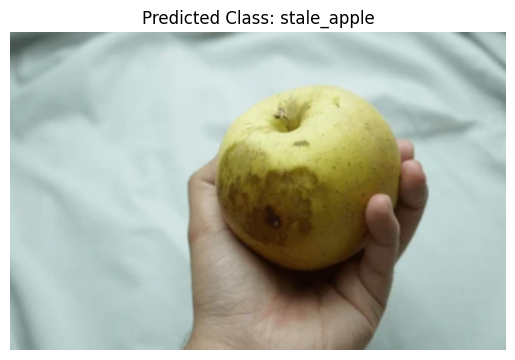

Predicted label: stale_apple


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to preprocess and predict on a new image
def predict_image(image_path):
    # Load the image and resize it to match the input shape expected by the model
    new_image = image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))

    # Convert the image to array format (Tensor)
    new_image = image.img_to_array(new_image)

    # Normalize the image (same preprocessing as done during training)
    new_image = new_image / 255.0

    # Reshape to add batch size (since the model expects a batch input)
    new_image = np.expand_dims(new_image, axis=0)  # Shape: (1, IMG_HEIGHT, IMG_WIDTH, 3)

    # Make a prediction
    prediction = model.predict(new_image)

    # Get the predicted class index
    predicted_class = tf.argmax(prediction, axis=1)

    # Get the label of the predicted class
    predicted_label = class_labels[predicted_class[0]]

    # Show the image along with predicted label
    plt.imshow(image.load_img(image_path))
    plt.title(f"Predicted Class: {predicted_label}")
    plt.axis('off')
    plt.show()

    return predicted_label

image_path = "/content/RottApple.png"
predicted_label = predict_image(image_path)
print(f"Predicted label: {predicted_label}")


In [ ]:
#Save the model
from google.colab import drive
drive.mount('/content/drive')

from tensorflow.keras.models import load_model
model.save('/content/drive/My Drive/FruitFreshness.h5')

Mounted at /content/drive
